In [1]:
import os

In [2]:
os.chdir('../')
%pwd

'/home/paladin/Downloads/Bixi-OD-Matrix-Prediction/Bixi-OD-Matrix-Prediction'

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TrainingAutoencoderConfig:    
    root_dir: Path
    trained_od_model_path: Path    
    base_od_model_path: Path
    trained_tensor_model_path: Path    
    base_tensor_model_path: Path     
    training_od_data: Path    
    training_tensor_data: Path    
    params_od_size: list
    params_tensor_size: list
    params_epochs: int
    params_batch_size: int   
    learning_rate: float
    validation_ratio: float

@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    ckeckpoint_model_filepath: Path
    patience: int

In [4]:
from timeseriesPredictor.utils import read_yaml, create_directories
from timeseriesPredictor.constants import *

In [5]:
class configurationManeger:
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH,
                 secret_filepath = SECRET_FILE_PATH,                 
                 params_filepath = PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath) 
        self.secret = read_yaml(secret_filepath)        
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_prepare_callbacks_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.ckeckpoint_model_filepath)

        create_directories([config.tensorboard_root_log_dir, model_ckpt_dir ])

        prepare_callbacks_config = PrepareCallbacksConfig(
           root_dir= config.root_dir,
           tensorboard_root_log_dir= config.tensorboard_root_log_dir,
           ckeckpoint_model_filepath=  config.ckeckpoint_model_filepath,
           patience = self.params.PATIENCE

        )

        return prepare_callbacks_config
    
    def get_autoencoder_training_config(self) -> TrainingAutoencoderConfig:
        config= self.config.training_autoencoder        
        
        create_directories([config.root_dir])

        training_autoencoder_config = TrainingAutoencoderConfig(
        root_dir= config.root_dir,
        trained_od_model_path= config.trained_od_model_path, 
        base_od_model_path = self.config.prepare_autoencoder_base_model.base_od_model_path,
        trained_tensor_model_path= config.trained_tensor_model_path, 
        base_tensor_model_path = self.config.prepare_autoencoder_base_model.base_tensor_model_path,
        training_od_data= self.config.data_transformation.local_train_od_dir,        
        training_tensor_data=self.config.data_transformation.local_train_tensor_dir,        
        params_epochs= self.params.EPOCHS, 
        params_batch_size= self.params.BATCH_SIZE,      
        params_od_size= self.params.OD_SIZE,
        params_tensor_size=self.params.TENSOR_SIZE,
        learning_rate= self.params.LEARNING_RATE,
        validation_ratio= self.params.VALIDATION_RATIO
        )

        return training_autoencoder_config

In [6]:
from timeseriesPredictor.utils import model_loss
import keras
import pickle

2023-08-11 17:46:31.078921: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-11 17:46:31.163750: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-11 17:46:31.164793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 17:46:32.576085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
class TrainingAutoencoder:
    def __init__(self, config: TrainingAutoencoderConfig):
        self.config= config

    def get_base_model(self):
        self.model = keras.models.load_model(self.config.base_od_model_path)  

    @staticmethod
    def load_file(path: Path):
        file= open(path, 'rb')
        obj = pickle.load(file)
        return obj

    def train(self, callback_list: list): 
        X_train = self.load_file(self.config.training_od_data) 
                

        history = self.model.fit(X_train, X_train,
            validation_split=self.config.validation_ratio,           
            epochs= self.config.params_epochs,
            batch_size = self.config.params_batch_size,            
            callbacks = callback_list
            )
        
        model_loss(history)

In [8]:
import sys
from timeseriesPredictor.exception import CustomException
from timeseriesPredictor.components.prepare_callbacks import PrepareCallbacks 

Epoch 1/50
17/17 [==============================] - 4s 212ms/step - loss: 0.8016 - MSE: 0.8016 - val_loss: 0.0356 - val_MSE: 0.0356
Epoch 2/50


/home/paladin/Downloads/Bixi-OD-Matrix-Prediction/Bixi-OD-Matrix-Prediction/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 3s 196ms/step - loss: 0.3526 - MSE: 0.3526 - val_loss: 0.0296 - val_MSE: 0.0296
Epoch 3/50
17/17 [==============================] - 3s 189ms/step - loss: 0.2590 - MSE: 0.2590 - val_loss: 0.0269 - val_MSE: 0.0269
Epoch 4/50
17/17 [==============================] - 3s 191ms/step - loss: 0.2089 - MSE: 0.2089 - val_loss: 0.0266 - val_MSE: 0.0266
Epoch 5/50
17/17 [==============================] - 3s 186ms/step - loss: 0.1736 - MSE: 0.1736 - val_loss: 0.0270 - val_MSE: 0.0270
Epoch 6/50
17/17 [==============================] - 3s 189ms/step - loss: 0.1484 - MSE: 0.1484 - val_loss: 0.0268 - val_MSE: 0.0268
Epoch 7/50
17/17 [==============================] - 3s 198ms/step - loss: 0.1277 - MSE: 0.1277 - val_loss: 0.0269 - val_MSE: 0.0269
Epoch 8/50
17/17 [==============================] - 3s 190ms/step - loss: 0.1122 - MSE: 0.1122 - val_loss: 0.0265 - val_MSE: 0.0265
Epoch 9/50
17/17 [==============================] - 3s 188ms/step - loss: 0.0993 - MSE:

/home/paladin/Downloads/Bixi-OD-Matrix-Prediction/Bixi-OD-Matrix-Prediction/src/timeseriesPredictor/utils.py:202: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


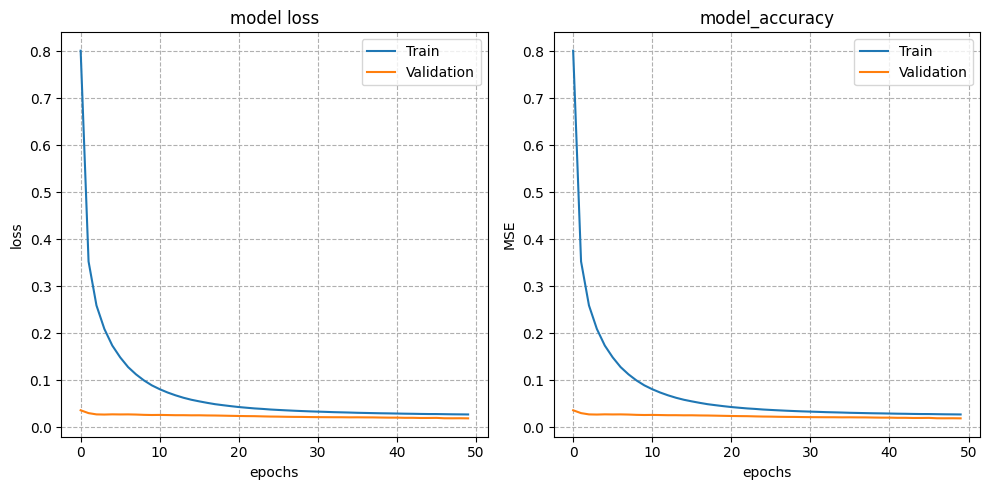

In [9]:
try:
    config = configurationManeger()
    prepare_callbacks_config = config.get_prepare_callbacks_config()
    prepare_callbacks = PrepareCallbacks(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_es_callbacks()

    training_config = config.get_autoencoder_training_config()
    training = TrainingAutoencoder(config= training_config)
    training.get_base_model()    
    training.train(callback_list= callback_list)

except Exception as e:
    raise CustomException(e, sys)